# Profiles of supergranule flow and vector potential

In [132]:
from __future__ import division
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import pyfits
import plotc
import read_params
np.set_printoptions(precision=3)
import scipy.integrate
import dbyd2
%load_ext Cython
import matplotlib.ticker
import scipy.fftpack
import scipy.special

def fitsread(f): return np.squeeze(pyfits.getdata(f)).byteswap().newbyteorder()

Lx=read_params.get_xlength()
nx=read_params.get_nx()
x=np.linspace(-Lx/2,Lx/2,nx,endpoint=False)
z=np.loadtxt(read_params.get_solarmodel(),usecols=[0])
Rsun = 6.95989467700E2
z=(z-1)*Rsun

c,rho = np.loadtxt(read_params.get_solarmodel(),usecols=[1,2],unpack=True)
c.shape += (1,)
rho.shape += (1,)
c = c/100 # Convert to m/s

def ind_x(x): return int((x/Lx+1/2)*nx)
def ind_z(z_coord): return abs(z-z_coord).argmin()

z_surf=ind_z(0)

dbyd2_z = np.zeros((1,)+z.shape,order='F')
dbyd2.dbyd2(dbyd2_z,np.asfortranarray(np.atleast_2d(z)),1)

def ddz(arr):
    arr = np.asfortranarray(arr).T
    numerator = np.zeros(arr.shape,order='F')
    dbyd2.dbyd2(numerator,arr,1)
    return (numerator/dbyd2_z).T

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


### Load output from Fortran

In [173]:
true_vx_sparc = fitsread('true_vx.fits')
true_vz_sparc = fitsread('true_vz.fits')
true_psi_sparc = fitsread('true_psi.fits')

### Analytical Expressions for velocity and vector potential
This is what the fortran code would compute without smoothing

In [182]:
%%cython

import numpy as np
cimport numpy as np
import scipy.fftpack
import read_params
import scipy.interpolate
import scipy.special

cdef double Lx = read_params.get_xlength()
cdef int nx=read_params.get_nx()
cdef int nz=read_params.get_nz()

import dbyd2
cdef double rsun = 6.95989467700E10


cdef ddz(arr):
    cdef np.ndarray[np.float64_t,ndim=1] z=np.loadtxt(read_params.get_solarmodel(),usecols=[0]) 
    cdef np.ndarray[np.float64_t,ndim=2] dbyd2_z = np.zeros((1,nz),order='F')
    dbyd2.dbyd2(dbyd2_z,np.asfortranarray(np.atleast_2d(z)),1)
    arr = np.asfortranarray(arr).T
    cdef np.ndarray[np.float64_t,ndim=2] numerator = np.zeros(arr.shape,order='F')
    dbyd2.dbyd2(numerator,arr,1)
    return (numerator/dbyd2_z).T

cpdef vel_psi_analytical():
    cdef np.ndarray[np.float64_t,ndim=2] v0_x = np.zeros((nz,nx))
    cdef np.ndarray[np.float64_t,ndim=2] v0_z = np.zeros((nz,nx))
    cdef np.ndarray[np.float64_t,ndim=2] psivar = np.zeros((nz,nx))    
    
    cdef double diml=rsun
    cdef double dimc = 10.0**6.
    cdef double dimrho = 10.0**(-3.0)
    cdef double Rchar = 15. *10.**8/diml
    cdef double con= (Lx*1e8/diml)/Rchar * 2
    cdef double kay = 2.*np.pi/(2.*Rchar)
    cdef double z0 = 1.-2.3*10**8./diml
    cdef double sigmaz = 0.912*10.**8./diml
    cdef double rand2 = 240.*100./dimc * 1./kay
    
    cdef np.ndarray[np.float64_t,ndim=2] rho0
    rho0 = np.empty((nz,1))
    cdef np.ndarray[np.float64_t,ndim=1] c = np.loadtxt(read_params.get_solarmodel(),usecols=[1])/dimc
    rho0[:,0] = np.loadtxt(read_params.get_solarmodel(),usecols=[2])/dimrho
    
    cdef np.ndarray[np.float64_t,ndim=2] gradrho0_z=ddz(rho0)
    
    cdef np.ndarray[np.float64_t,ndim=1] x = np.linspace(0.,1.,nx,endpoint=False)
    cdef np.ndarray[np.float64_t,ndim=1] z=np.loadtxt(read_params.get_solarmodel(),usecols=[0]) 
    
    cdef np.ndarray[np.float64_t,ndim=1] signt=np.sign(x-0.5)
    cdef np.ndarray[np.float64_t,ndim=1] rand1=abs((x-0.5)*Lx*1e8/diml)*kay
    cdef np.ndarray[np.float64_t,ndim=2] bes=np.zeros((3,x.size))
    bes[0] = scipy.special.j0(rand1)
    bes[1] = scipy.special.j1(rand1)
    bes[2] = scipy.special.jn(2,rand1)
            
    cdef np.ndarray[np.float64_t,ndim=2] exptemp 
    exptemp = np.exp(-abs((x[np.newaxis,:]-0.5)*con) - (z[:,np.newaxis] -z0)**2./(2.*sigmaz**2.))

    cdef np.ndarray[np.float64_t,ndim=2] signed_bes_times_exptemp
    signed_bes_times_exptemp = signt*bes[1] * rand2 * exptemp
    
    v0_z  = rand2*(0.5*(bes[0]-bes[2])*kay - 2*bes[1]/Rchar) * exptemp

    v0_x  = -signed_bes_times_exptemp*(-2.*(z[:,np.newaxis]-z0)/(2.*sigmaz**2.) + gradrho0_z/rho0)

    psivar =  signed_bes_times_exptemp/c[:,np.newaxis]        
            
    psivar *= diml/1e8
    v0_x*=dimc*10.**(-2.)
    v0_z*=dimc*10.**(-2.)
    return v0_x,v0_z,psivar

cpdef fft_deriv_x(arr):
    cdef int zind
    cdef np.ndarray[np.float64_t, ndim=2] darr = np.zeros_like(arr)
    cdef np.ndarray[np.float64_t,ndim=1] az
    for zind,az in enumerate(arr):
        darr[zind]=scipy.fftpack.diff(az,period=float(Lx))
    return darr

cpdef fft_int_x(arr):
    cdef int zind,nx
    cdef float az_mean
    nx = arr.shape[1]
    cdef np.ndarray[np.float64_t, ndim=2] darr = np.zeros_like(arr)
    cdef np.ndarray[np.float64_t,ndim=1] x=np.linspace(-Lx/2.,Lx/2.,nx,endpoint=False)
    cdef np.ndarray[np.float64_t,ndim=1] az
    
    for zind,az in enumerate(arr):
        az_mean = np.mean(az)
        darr[zind]=scipy.fftpack.diff(az-az_mean,period=Lx,order=-1)
        darr[zind]+=az_mean*(x+Lx/2.)
        
    return darr

cpdef spline_int_z(arr):
    cdef int xind,zind,nx,nz
    nx = arr.shape[1]
    nz = arr.shape[0]
    cdef np.ndarray[np.float64_t, ndim=2] arr_int = np.zeros_like(arr)
    cdef np.ndarray[np.float64_t,ndim=1] z
    z = np.loadtxt(read_params.get_solarmodel(),usecols=[0]); z=(z-1.)*695.8
    cdef float z_lower=z[0]
    cdef np.ndarray[np.float64_t,ndim=1] arr_x_zlow,z_low
    
    for xind in xrange(nx):
        for zind in xrange(5,nz):
            arr_x_zlow = arr[:zind,xind]
            z_low = z[:zind]
            s=scipy.interpolate.UnivariateSpline(z_low,arr_x_zlow)
            arr_int[zind,xind]=s.integral(z_lower,z[zind])
            
    return arr_int

## Fourier smoothing

In [170]:
def fourier_smoothing(arr,nk):
    arr_fft = np.fft.fft(arr,axis=1)
    k = np.fft.fftfreq(nx,1./nx)
    sigmak = nk # Factor of 2*pi/Lx cancels out in numerator and denominator 
    smoothing_fn = np.exp(-k**2/(2*sigmak**2))
    
    arr_fft*=smoothing_fn
    
    return np.fft.ifft(arr_fft,axis=1).real

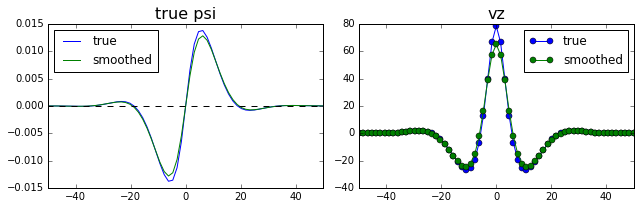

In [174]:
true_psi_smoothed=fourier_smoothing(true_psi_sparc,70)

gl=plotc.gridlist(1,2)
plt.subplot(next(gl));
plt.plot(x,true_psi_sparc[ind_z(-2.3)],label="true");
plt.plot(x,true_psi_smoothed[ind_z(-2.3)],label="smoothed");
plt.plot(x,np.zeros_like(x),'k--');
plt.xlim(-50,50)
plt.title("true psi",fontsize=16)
plt.legend(loc="best")

vz_from_smoothed_psi = fft_deriv_x(rho*c*true_psi_smoothed)/rho

plt.subplot(next(gl))
plt.plot(x,true_vz_sparc[ind_z(-2.3)],label="true",marker="o");
plt.plot(x,vz_from_smoothed_psi[ind_z(-2.3)],label="smoothed",marker="o");
plt.xlim(-50,50)
plt.legend(loc="best")
plt.title("vz",fontsize=16);

plt.gcf().set_size_inches(9,3)
plt.tight_layout()

In [175]:
vx_from_psi_dbyd2 = -1/rho*ddz(rho*c*true_psi_sparc)
vz_from_psi_fft = c*fft_deriv_x(true_psi_sparc) # move functions of z outside, rho cancels out

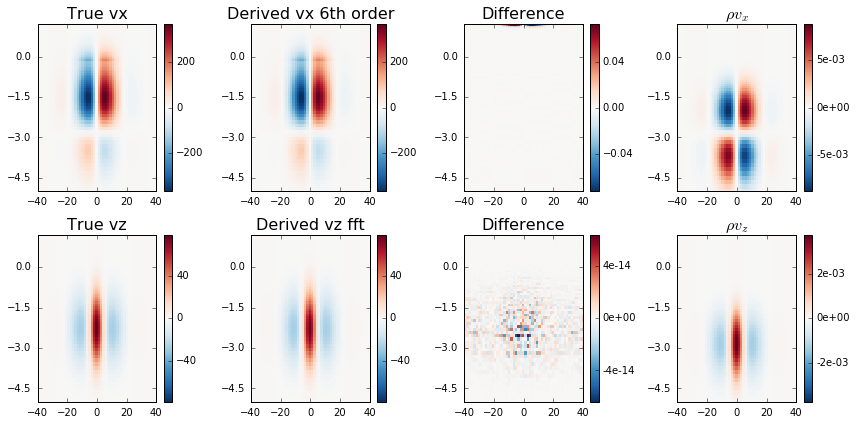

In [183]:
gl=plotc.gridlist(2,4)

plotc.colorplot(true_vx_sparc,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("True vx",fontsize=16)
plotc.colorplot(vx_from_psi_dbyd2,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Derived vx 6th order",fontsize=16)
plotc.colorplot(true_vx_sparc-vx_from_psi_dbyd2,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Difference",fontsize=16)
plotc.colorplot(rho*vx_from_psi_dbyd2,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title(r"$\rho v_x$",fontsize=16)

plotc.colorplot(true_vz_sparc,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("True vz",fontsize=16)
plotc.colorplot(vz_from_psi_fft,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Derived vz fft",fontsize=16)
plotc.colorplot(true_vz_sparc-vz_from_psi_fft,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Difference",fontsize=16)
plotc.colorplot(rho*vz_from_psi_fft,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title(r"$\rho v_z$",fontsize=16)

plt.gcf().set_size_inches(12,6);
plt.tight_layout()

In [177]:
print "vz misft lower limit",np.sum((true_vz_sparc-vz_from_psi_fft)**2)/np.sum(true_vz_sparc**2)
print "vx misft lower limit",np.sum((true_vx_sparc-vx_from_psi_dbyd2)**2)/np.sum(true_vx_sparc**2)

vz misft lower limit 2.16323898839e-30
vx misft lower limit 2.42340184292e-09


## Continuity

3.44619E-07
1.09589E-03
2.79985E-17


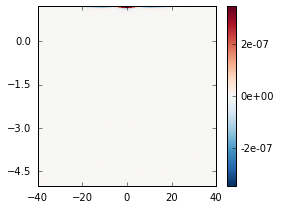

In [178]:
def continuity(vx,vz):
    dz_rhovz = ddz(rho*vz)
    dx_rhovx = fft_deriv_x(rho*vx)
    cont =  (dz_rhovz+dx_rhovx)/(ddz(rho)*c)
    print "{:10.5E}".format(abs(cont).max())
    return cont
    
cont=continuity(true_vx_sparc,true_vz_sparc)
continuity(vx_analytical,vz_analytical);
continuity(vx_from_psi_dbyd2,vz_from_psi_fft);

gl=gridlist(1,1)
plotc.colorplot(cont,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.gcf().set_size_inches(4,3)
plt.tight_layout()

## Vector potential from velocity

The vector potential that gives rise to these velocity fields can be computed in polar as well as Cartesian coordinates. The difference is that the vector potential is along $\mathbf{e}_\phi$ in polar and $\mathbf{e}_y$ in Cartesian. 

### Cartesian coordinates
 
 $$ \psi\left(x,z\right)=\frac{1}{\rho\left(z\right)c\left(z\right)}\int_{-L_x/2}^{x}dx^{\prime}\,\rho\left(z\right)v_{z}\left(x^{\prime},z\right).$$
 
or alternately in terms of $v_x$
 
 $$ \psi\left(x,z\right)=-\frac{1}{\rho\left(z\right)c\left(z\right)}\int_{z_{b}}^{z}dz^{\prime}\,\rho\left(z^{\prime}\right)v_{x}\left(x,z^{\prime}\right).$$
 
Let us do $v_z$ first

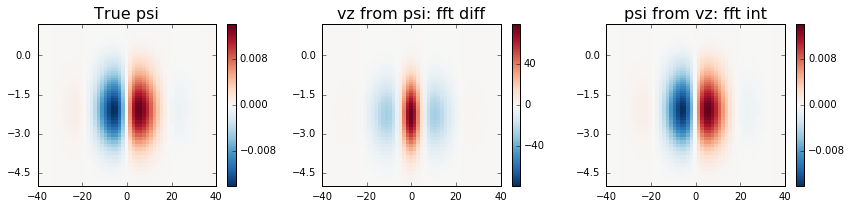

In [179]:
gl=plotc.gridlist(1,3)

plotc.colorplot(true_psi_sparc,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("True psi",fontsize=16)

plotc.colorplot(vz_from_psi_fft,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("vz from psi: fft diff",fontsize=16)

psi_from_vz_from_psi = fft_int_x(rho*vz_from_psi_fft)/(rho*c)
plotc.colorplot(psi_from_vz_from_psi,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("psi from vz: fft int",fontsize=16)

plt.gcf().set_size_inches(12,3)
plt.tight_layout()

psi_from_vz_from_psi=None

#### Let us try the same with $v_x$

In [115]:
psi_from_analytical_vx_trapz=-scipy.integrate.cumtrapz(rho*true_vx_sparc,x=z,axis=0,initial=0)/(rho*c)
psi_from_numerical_vx_trapz=-scipy.integrate.cumtrapz(rho*vx_from_psi_dbyd2,x=z,axis=0,initial=0)/(rho*c)
# psi_from_analytical_vx_spline=-spline_int_z(rho*true_vx_sparc)/(rho*c)
# psi_from_numerical_vx_spline=-spline_int_z(rho*vx_from_psi_dbyd2)/(rho*c)

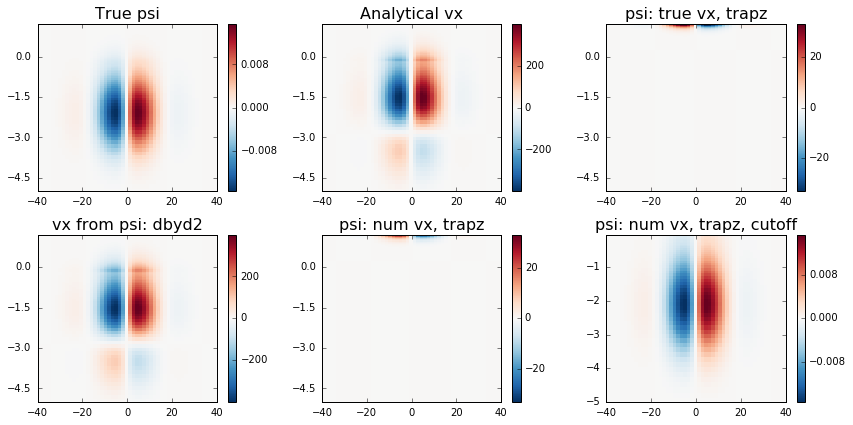

In [116]:
gl=plotc.gridlist(2,3)

plotc.colorplot(true_psi_sparc,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("True psi",fontsize=16);

plotc.colorplot(true_vx_sparc,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Analytical vx",fontsize=16);

plotc.colorplot(psi_from_analytical_vx_trapz,x=x,y=z,xr=[-40,40],yr=[-5,None],
                centerzero=True,sp=next(gl));
plt.title("psi: true vx, trapz",fontsize=16);

plotc.colorplot(vx_from_psi_dbyd2,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("vx from psi: dbyd2",fontsize=16);

plotc.colorplot(psi_from_numerical_vx_trapz,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("psi: num vx, trapz",fontsize=16);

upper_cutoff=ind_z(0)
plotc.colorplot(psi_from_numerical_vx_trapz[:upper_cutoff],x=x,y=z[:upper_cutoff],
                xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("psi: num vx, trapz, cutoff",fontsize=16);

# plotc.colorplot(psi_from_analytical_vx_spline,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
# plt.title("psi: true vx, spline",fontsize=16);

# plotc.colorplot(psi_from_numerical_vx_spline,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
# plt.title("psi: num vx, spline",fontsize=16);

plt.gcf().set_size_inches(12,6)
plt.tight_layout()

Inspecting $\rho v_x$

rho vx max 0.00539689230914
rho vx min -0.00503894363107


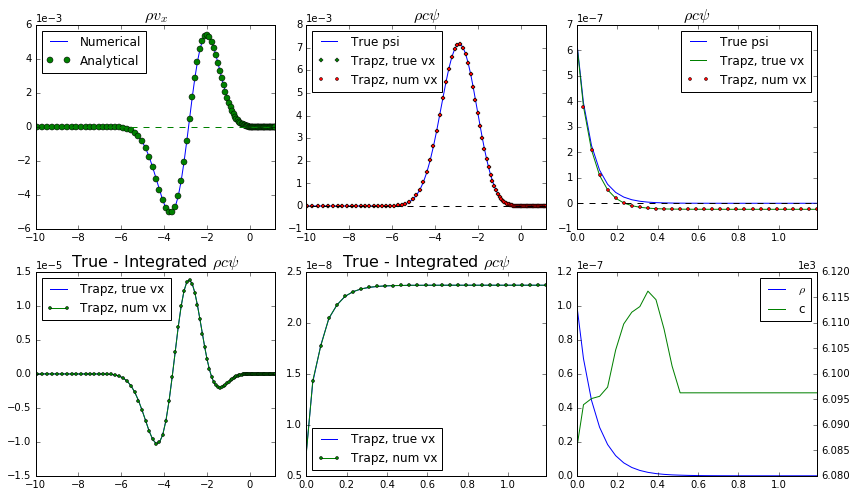

In [117]:
gl=plotc.gridlist(2,3)

x_cut_ind = ind_x(3) # Mm to pixel

plt.subplot(next(gl))
plt.plot(z,(rho*vx_from_psi_dbyd2)[:,x_cut_ind],label="Numerical");
plt.plot(z,(rho*true_vx_sparc)[:,x_cut_ind],'o',label="Analytical");
plt.plot(z,np.zeros_like(z),'g--');
plt.legend(loc="best")
plt.xlim(-10,z[-1]);
plt.title(r"$\rho v_x$",fontsize=16)
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

print "rho vx max",(rho*vx_from_psi_dbyd2)[:,x_cut_ind].max()
print "rho vx min",(rho*vx_from_psi_dbyd2)[:,x_cut_ind].min()

plt.subplot(next(gl))
plt.plot(z,(rho*c*true_psi_sparc)[:,x_cut_ind],label="True psi");
plt.plot(z,(rho*c*psi_from_analytical_vx_trapz)[:,x_cut_ind],label="Trapz, true vx",
        marker="D",markersize=3,ls="None");
plt.plot(z,(rho*c*psi_from_numerical_vx_trapz)[:,x_cut_ind],label="Trapz, num vx",
         marker='o',markersize=3,ls="None");
plt.plot(z,np.zeros_like(z),color='k',ls="dashed")
plt.xlim(-10,z[-1]);
plt.title(r"$\rho c \psi$",fontsize=16)
plt.legend(loc="best")
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

z_cutoff_ind=ind_z(0)
plt.subplot(next(gl))
plt.plot(z[z_cutoff_ind:],(rho*c*true_psi_sparc)[z_cutoff_ind:,x_cut_ind],label="True psi");
plt.plot(z[z_cutoff_ind:],(rho*c*psi_from_analytical_vx_trapz)[z_cutoff_ind:,x_cut_ind],label="Trapz, true vx");
plt.plot(z[z_cutoff_ind:],(rho*c*psi_from_numerical_vx_trapz)[z_cutoff_ind:,x_cut_ind],label="Trapz, num vx",
         marker='o',markersize=3,ls="None");
plt.xlim(0,z[-1]);
plt.plot(np.zeros_like(z),'k--');
plt.title(r"$\rho c \psi$",fontsize=16)
plt.legend(loc="best")
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

plt.subplot(next(gl))
plt.plot(z,(rho*c*(true_psi_sparc-psi_from_analytical_vx_trapz))[:,x_cut_ind],label="Trapz, true vx");
plt.plot(z,(rho*c*(true_psi_sparc-psi_from_numerical_vx_trapz))[:,x_cut_ind],label="Trapz, num vx",
        marker='o',markersize=3);
plt.xlim(-10,z[-1]);
plt.legend(loc="best")
plt.title(r"True - Integrated $\rho c \psi$",fontsize=16)
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

plt.subplot(next(gl))
plt.plot(z[z_cutoff_ind:],(rho*c*(true_psi_sparc-psi_from_analytical_vx_trapz))[z_cutoff_ind:,x_cut_ind],
         label="Trapz, true vx");
plt.plot(z[z_cutoff_ind:],(rho*c*(true_psi_sparc-psi_from_numerical_vx_trapz))[z_cutoff_ind:,x_cut_ind],
         label="Trapz, num vx",marker='o',markersize=3);
plt.xlim(0,z[-1]);
plt.legend(loc="best")
plt.title(r"True - Integrated $\rho c \psi$",fontsize=16)
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

z_cutoff_ind=ind_z(0)
plt.subplot(next(gl))
l1=plt.plot(z[z_cutoff_ind:],rho.flatten()[z_cutoff_ind:],'b',label=r"$\rho$")
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
plt.gca().twinx()
l2=plt.plot(z[z_cutoff_ind:],c.flatten()[z_cutoff_ind:],'g',label="c")
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
plt.xlim(0,z[-1]);
lines=[l for l in l1+l2]
labels=[l.get_label() for l in lines]
plt.legend(lines,labels,loc="best")

plt.gcf().set_size_inches(12,7);
plt.tight_layout()

Integrating $v_x$ is a numerical problem

# Psi with cutoff

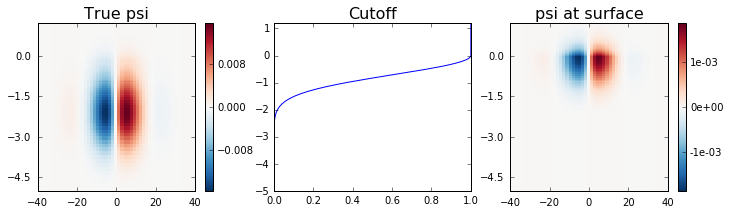

In [30]:
plotc.colorplot(true_psi_sparc,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=131);
plt.title("True psi",fontsize=16)

cutoff = z**2/1
cutoff[cutoff>100]=100
cutoff[z_surf:]=0.
cutoff = np.exp(-cutoff)
cutoff.shape += (1,)
psi_above_surface = true_psi_sparc.copy()
psi_above_surface[:z_surf] = np.tile(np.atleast_2d(psi_above_surface[z_surf]),(z_surf,1))
psi_above_surface*=cutoff

plt.subplot(132)
plt.plot(cutoff,z);
plt.ylim(-5,z[-1])
plt.title("Cutoff",fontsize=16)

plotc.colorplot(psi_above_surface,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=133);
plt.title("psi at surface",fontsize=16)

plt.gcf().set_size_inches(12,3)

Velocity corresponding to surface matched potential

In [31]:
vx_starting = -ddz(rho*c*psi_above_surface)/rho
vz_starting = fft_deriv_x(rho*c*psi_above_surface)/rho

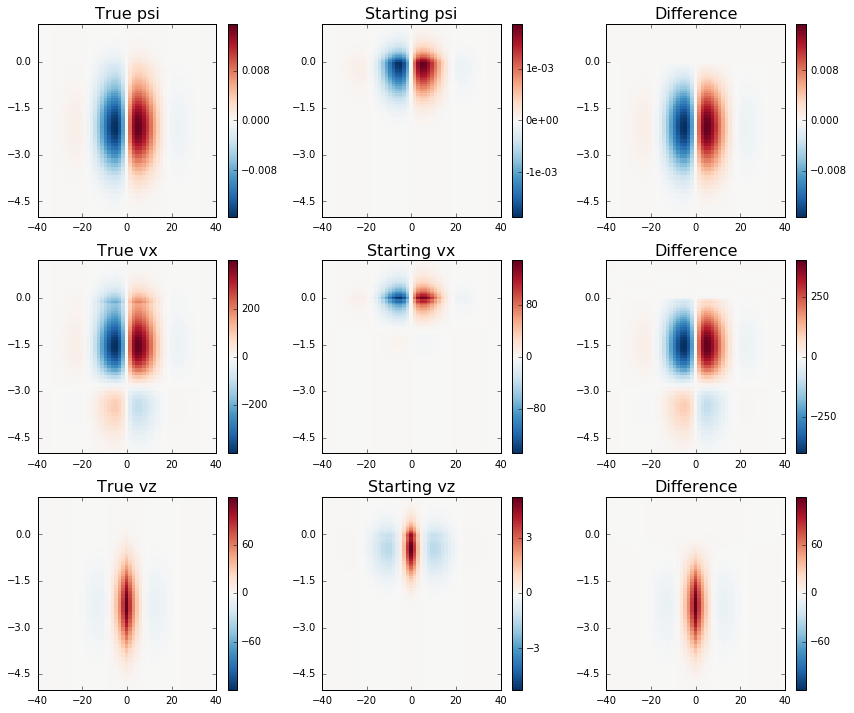

In [12]:
gl=plotc.gridlist(3,3)

plotc.colorplot(true_psi_sparc,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("True psi",fontsize=16)

plotc.colorplot(psi_above_surface,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Starting psi",fontsize=16)

plotc.colorplot(true_psi_sparc-psi_above_surface,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Difference",fontsize=16)

plotc.colorplot(vx,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("True vx",fontsize=16)

plotc.colorplot(vx_starting,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Starting vx",fontsize=16)

plotc.colorplot(vx-vx_starting,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Difference",fontsize=16)

plotc.colorplot(vz,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("True vz",fontsize=16)

plotc.colorplot(vz_starting,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Starting vz",fontsize=16)

plotc.colorplot(vz-vz_starting,x=x,y=z,xr=[-40,40],yr=[-5,None],centerzero=True,sp=next(gl));
plt.title("Difference",fontsize=16)

plt.gcf().set_size_inches(12,10)
plt.tight_layout()

In [33]:
pyfits.writeto("model_psi_ls00.fits",psi_above_surface,clobber=True)
pyfits.writeto("vx_surface_constrained.fits",vx_starting,clobber=True)
pyfits.writeto("vz_surface_constrained.fits",vz_starting,clobber=True)